In [2]:
import gensim.downloader as api

# Will take 10 mins
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [3]:
wv.similarity(w1 = 'good', w2 = 'great')

0.729151

In [4]:
wv.most_similar('sanjay')

[('varun', 0.7260806560516357),
 ('rahul', 0.7239071130752563),
 ('vijay', 0.7179754376411438),
 ('mohan', 0.7164943814277649),
 ('rajiv', 0.7160934209823608),
 ('kiran', 0.712263286113739),
 ('ravi', 0.7102879881858826),
 ('ajay', 0.7028993368148804),
 ('irfan', 0.7000676393508911),
 ('sinha', 0.6937455534934998)]

In [5]:
wv.most_similar(positive = ['king','woman'], negative = ['man'])

[('queen', 0.7118193507194519),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321839332581),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593831062317),
 ('monarchy', 0.5087411999702454)]

In [7]:
wv.doesnt_match(['toyota','bmw','mercedes','sanjay'])

'sanjay'

In [8]:
glv = api.load('glove-twitter-25')

[===============================================---] 94.0% 98.5/104.8MB downloaded


In [9]:
glv.most_similar('sanjay')

[('rajnath', 0.9155257344245911),
 ('ayman', 0.9131414294242859),
 ('hamza', 0.909331202507019),
 ('khurshid', 0.9065790772438049),
 ('manmohan', 0.9056894183158875),
 ('tariq', 0.9051162600517273),
 ('farooq', 0.8974254131317139),
 ('jaitley', 0.8956030011177063),
 ('prashant', 0.8932253122329712),
 ('malloy', 0.8899197578430176)]

In [10]:
glv.doesnt_match(['toyota','bmw','mercedes','sanjay'])

'sanjay'

#Classification

In [11]:
import pandas as pd
import numpy as np

df = pd.read_csv('fake_and_real_news.csv')
print(df.shape)
df.head()

(9900, 2)


,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [12]:
df.label.value_counts()

Fake    5000
Real    4900
Name: label, dtype: int64

In [13]:
df['label_num'] = df['label'].map({
    'Real': 0,
    'Fake': 1
})
df.head()

,Text,label,label_num
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,1
1,U.S. conservative leader optimistic of common ...,Real,0
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,0
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,1
4,Democrats say Trump agrees to work on immigrat...,Real,0


In [18]:
import spacy

!python -m spacy download en_core_web_lg

2023-08-11 09:45:29.974346: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 692.4 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [19]:
nlp = spacy.load('en_core_web_lg')

def preprocess_and_vectorize(text):
  doc = nlp(text)
  filtered_tokens = []


  for token in doc:
    if token.is_stop and token.is_punct:
      continue
    filtered_tokens.append(token.lemma_)

  return wv.get_mean_vector(filtered_tokens)

In [20]:
df['vector'] = df['Text'].apply(lambda text: preprocess_and_vectorize(text))

In [21]:
df.head()

,Text,label,label_num,vector
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,1,"[0.017310064, 0.015067152, 0.008186125, 0.0387..."
1,U.S. conservative leader optimistic of common ...,Real,0,"[0.015988229, 0.009727976, 0.015578468, 0.0332..."
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,0,"[0.019331463, 0.01067083, 0.011367614, 0.04468..."
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,1,"[0.01604314, 0.015978297, 0.01628747, 0.036516..."
4,Democrats say Trump agrees to work on immigrat...,Real,0,"[0.0062056324, 0.013996333, 0.013250186, 0.038..."


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.vector.values,
    df.label_num,
    test_size=0.2,
    random_state=2022,
    stratify=df.label_num
)

In [23]:
print("Shape of X_train before reshaping: ", X_train.shape)
print("Shape of X_test before reshaping: ", X_test.shape)


X_train_2d = np.stack(X_train)
X_test_2d =  np.stack(X_test)

print("Shape of X_train after reshaping: ", X_train_2d.shape)
print("Shape of X_test after reshaping: ", X_test_2d.shape)

Shape of X_train before reshaping:  (7920,)
Shape of X_test before reshaping:  (1980,)
Shape of X_train after reshaping:  (7920, 300)
Shape of X_test after reshaping:  (1980, 300)


In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

clf = GradientBoostingClassifier()
clf.fit(X_train_2d, y_train)

y_pred = clf.predict(X_test_2d)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.97      0.98      1000

    accuracy                           0.98      1980
   macro avg       0.98      0.98      0.98      1980
weighted avg       0.98      0.98      0.98      1980



Text(95.72222222222221, 0.5, 'Truth')

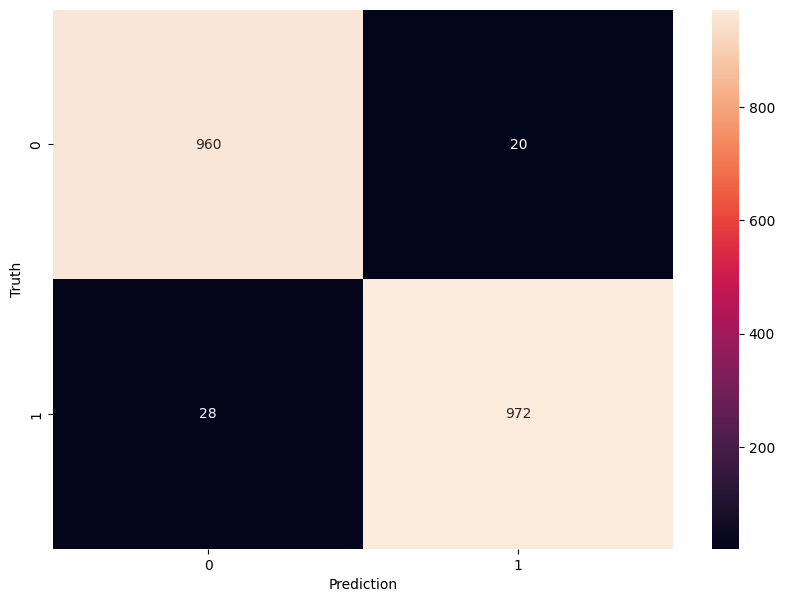

In [25]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sn

cm = confusion_matrix(y_test, y_pred)
cm

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')